In [434]:
import math as ma
import yfinance as yf
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential, Model
from keras.initializers import glorot_uniform
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation, Input, concatenate
import datetime as dt
import matplotlib.pyplot as plt 
import pandas_ta as ta
import tensorflow as tf

from keras import optimizers
from keras.callbacks import History

np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

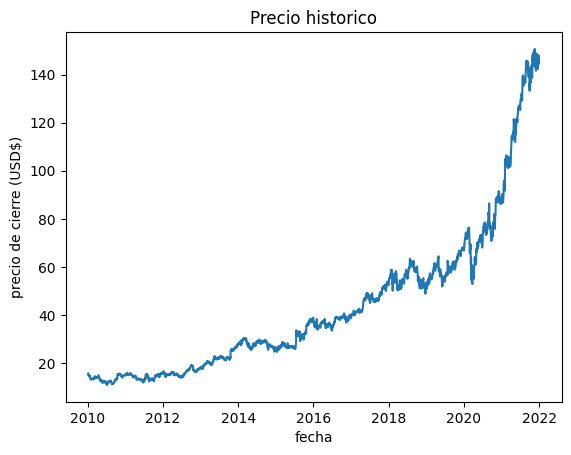

(330, 5)


In [435]:
#var de testeo
stride = 30
simbolo = "Goog"
#conseguir la data
#dfTrain = web.DataReader('SYP', 'stooq', dt.datetime(2020,1,1), dt.datetime(2023,1,1))
dfTrain = yf.download(tickers= simbolo, start= dt.datetime(2010,1,1), end= dt.datetime(2022,1,1))
dfTest =  yf.download(simbolo, start = dt.datetime(2022,1,1),end = dt.date.today()) #dt.date.today())

dataTrain = dfTrain.filter(['Close'])
grafData = dataTrain.copy()
#agrego indicadores: 
dataTrain['RSI']=ta.rsi(dataTrain['Close'], length=15)
dataTrain['EMAF']=ta.ema(dataTrain['Close'], length=20)
dataTrain['EMAM']=ta.ema(dataTrain['Close'], length=100)
dataTrain['EMAS']=ta.ema(dataTrain['Close'], length=150)
dataTrain.dropna(inplace=True)
#dataTrain.reset_index(inplace = True)
#agrego indicadores para test: 
dataTest = dfTest.filter(['Close'])

dataTest['RSI']=ta.rsi(dataTest['Close'], length=15)
dataTest['EMAF']=ta.ema(dataTest['Close'], length=20)
dataTest['EMAM']=ta.ema(dataTest['Close'], length=100)
dataTest['EMAS']=ta.ema(dataTest['Close'], length=150)

dataTestAux = dataTest['Close'][:149]
dataTest.dropna(inplace=True)




plt.title('Precio historico')
plt.plot(grafData)
plt.xlabel("fecha")
plt.ylabel("precio de cierre (USD$)")
# plt.axis((2020,2023,ma.floor(min(dataTrain.values)), ma.ceil(max(dataTrain.values))))
plt.show()


# print((dataTrain['Close'][0] - min(dataTrain['Close']))/(max(dataTrain['Close'])-min(dataTrain['Close'])))
# print(dataTrain)

dataTrain =dataTrain.values 
dataTest = dataTest.values


# dataTrain = np.flip(dataTrain)
# dataTest = np.flip(dataTest)

print((dataTest.shape))


In [436]:
#normalizar la data 
scaler = MinMaxScaler(feature_range=(0,1))
dataNormTrain = scaler.fit_transform(dataTrain)
dataNormTest = scaler.fit_transform(dataTest)
print(dfTest['Close'][-10:])

# print(dataNormTrain[0:stride+1,:])
# print(dataNormTrain[stride,:])
# print(dataNormTrain)
print(dataTest[-10:,0])
print(dataNormTest[-10:,0])

# print(dataNormTest[0:stride+1,:])
# print(dataNormTest[stride,:])

Date
2023-11-14    135.429993
2023-11-15    136.380005
2023-11-16    138.699997
2023-11-17    136.940002
2023-11-20    137.919998
2023-11-21    138.619995
2023-11-22    140.020004
2023-11-24    138.220001
2023-11-27    138.050003
2023-11-28    138.619995
Name: Close, dtype: float64
[135.4299927 136.3800049 138.6999969 136.9400024 137.9199982 138.6199951
 140.0200043 138.2200012 138.0500031 138.6199951]
[0.8922865 0.9086069 0.9484625 0.9182272 0.9350627 0.9470881 0.9711391
 0.9402165 0.9372961 0.9470881]


In [437]:
#crear el dataset de entrenamiento 
#separar entre X e Y dataSets
#X son las entradas e Y es la salida esperada
x_train = []
y_train = []


for i in range(stride, len(dataNormTrain)):
    x_train.append(dataNormTrain[i-stride:i, :])
    y_train.append(dataNormTrain[i,0])
    # if i<=stride:
    #     print(x_train)
    #     print(y_train)

#print(x_train[3], y_train[:3])

# for i in range(len(x_train)):
#     print(x_train[i], y_train[i]) 

#yi = np.array(dataNormTrain[stride:,-1])
#y=np.reshape(yi,(len(yi),1))

# for i in range(stride,len(dataNormTrain)):
#     x_train.append(dataNormTrain[i-stride:i,0])
#     y_train.append(dataNormTrain[i,0])




In [438]:
#hacerlos np.arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
#el modelo necesita el numero de samples, de datos y de features

In [439]:
#construir la red LSTM 
model = Sequential() 

model.add(LSTM(150, return_sequences= True, input_shape = (stride, x_train.shape[2])))
model.add(Dropout(0.25))
model.add(LSTM(200, return_sequences= False))
model.add(Dropout(0.25))
#inputs = LSTM(100, name='first_layer')(lstm_input)

model.add(Dense(1, activation= 'linear'))
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
model.fit(x=x_train, y=y_train, epochs=30, batch_size=15, shuffle=True, validation_split = 0.1) 

Epoch 1/30
171/171 [==============================] - 11s 40ms/step - loss: 0.4735 - val_loss: 0.4571
Epoch 2/30
171/171 [==============================] - 6s 35ms/step - loss: 0.4173 - val_loss: 0.4470
Epoch 3/30
171/171 [==============================] - 6s 35ms/step - loss: 0.4166 - val_loss: 0.4470
Epoch 4/30
171/171 [==============================] - 6s 34ms/step - loss: 0.4159 - val_loss: 0.4469
Epoch 5/30
171/171 [==============================] - 6s 35ms/step - loss: 0.4155 - val_loss: 0.4484
Epoch 6/30
171/171 [==============================] - 6s 34ms/step - loss: 0.4156 - val_loss: 0.4450
Epoch 7/30
171/171 [==============================] - 6s 35ms/step - loss: 0.4154 - val_loss: 0.4475
Epoch 8/30
171/171 [==============================] - 6s 34ms/step - loss: 0.4154 - val_loss: 0.4482
Epoch 9/30
171/171 [==============================] - 6s 34ms/step - loss: 0.4155 - val_loss: 0.4573
Epoch 10/30
171/171 [==============================] - 6s 34ms/step - loss: 0.4154 - val_l

In [440]:
#crea datos para test
#separa en X y en Y 

testData = np.concatenate((dataNormTrain[-stride:,:],dataNormTest)) 
#!no esta bien pq se saltea los que borre de test
#print(testData)
x_test = []
y_test = dataTest[:,0]

# print(len(dataTest))

for i in range(stride, len(testData)):
     x_test.append(testData[i-stride:i,:])
#X contiene los valores no contempleados en el train, e y contiene la salida esperada
x_test = np.array(x_test)

#x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],x_test.shape[2]))
#print(x_test[1])
#print(y_test[1])


In [441]:
#print(model.predict(x_test[:-30]))

In [442]:
#prediccion del modelo para test

prediccion = np.zeros((x_test.shape[0],5))
aux = model.predict(x_test)
print(aux.shape)
aux = np.reshape(aux,(aux.shape[0]))
#print(aux)

prediccion[:,0] = aux[:]
prediccion = scaler.inverse_transform(prediccion)
prediccion = prediccion[:,0]
# print(prediccion.shape[0])

11/11 [==============================] - 1s 16ms/step
(330, 1)


In [443]:
#calcular error del modelo (RMSE)
rmse = np.sqrt(np.mean((prediccion - y_test)**2))
print('RMSE: ',"{:.2f}".format(rmse))


RMSE:  6.81


In [444]:
#Arma las estructuras para  graficar
train = dfTrain
valid = dfTest
prediccion = np.concatenate((dataTestAux[:], prediccion[:]))

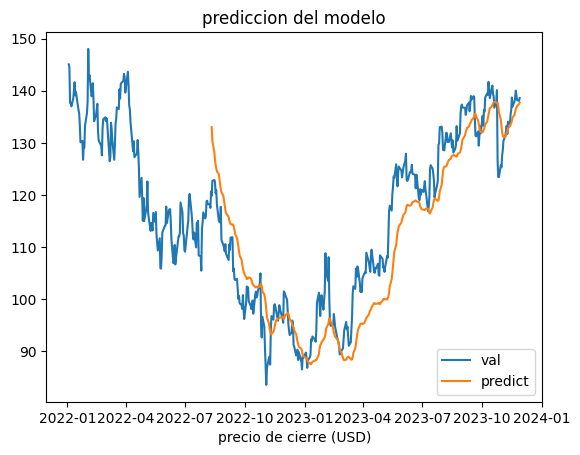

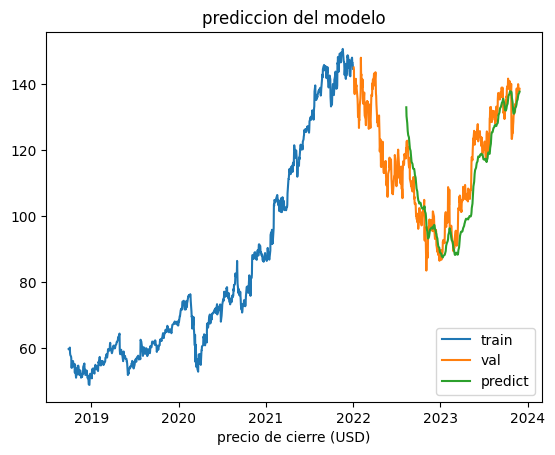

In [445]:

#testData = np.concatenate((dataNormTrain[-stride:,:],dataNormTest)) 
valid['Predictions'] = prediccion

#plot
plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
#plt.plot(train['Close'][2000:])
plt.plot(valid['Close']) 
plt.plot(valid['Predictions'][152:])
plt.legend(['val', 'predict'], loc = 'lower right')
plt.figure()


plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
plt.plot(train['Close'][2200:])
plt.plot(valid['Close']) 
plt.plot(valid['Predictions'][152:])
plt.legend(['train', 'val', 'predict'], loc = 'lower right')
plt.show()


In [446]:
valid = valid[153:]

C:\Users\nahue\AppData\Local\Temp\ipykernel_188\1019828568.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  difPred = [valid['Predictions'][i+1] - valid['Predictions'][i] for i in range(valid.shape[0]-1)]
C:\Users\nahue\AppData\Local\Temp\ipykernel_188\1019828568.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  difVal = [valid['Close'][i+1] - valid['Close'][i] for i in range(valid.shape[0]-1)]


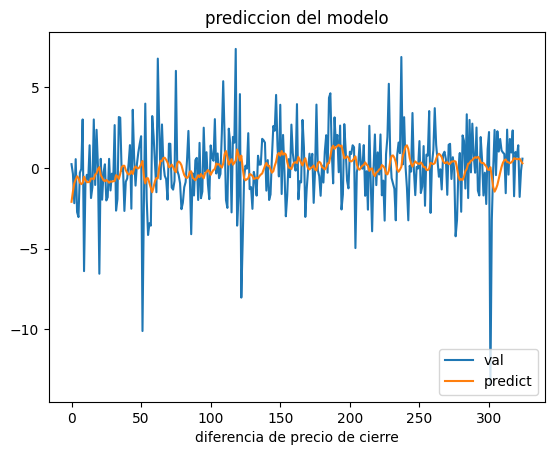

In [447]:
difPred = [valid['Predictions'][i+1] - valid['Predictions'][i] for i in range(valid.shape[0]-1)]
difVal = [valid['Close'][i+1] - valid['Close'][i] for i in range(valid.shape[0]-1)]
difPred = np.array(difPred)
difVal = np.array(difVal)


plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("diferencia de precio de cierre")
plt.plot(difVal)
plt.plot(difPred) 
plt.legend(['val', 'predict'], loc = 'lower right')
plt.show()

In [448]:
combined_arrays = zip(difVal, difPred)
same_sign_count = sum(1 for a, b in combined_arrays if (a > 0 and b > 0) or (a < 0 and b < 0))
print('Promedio de diferencias:',(same_sign_count / difVal.shape[0])*100)

Promedio de diferencias: 48.61538461538461


In [449]:
#imprimir los valores
print(valid[['Close', 'Predictions']][149:])

                 Close  Predictions
Date                               
2023-03-17  102.459999    89.619831
2023-03-20  101.930000    90.541438
2023-03-21  105.839996    91.302837
2023-03-22  104.220001    92.345055
2023-03-23  106.260002    93.163234
...                ...          ...
2023-11-21  138.619995   135.930450
2023-11-22  140.020004   136.467150
2023-11-24  138.220001   137.039048
2023-11-27  138.050003   137.466644
2023-11-28  138.619995   137.748301

[177 rows x 2 columns]


In [450]:
#simulacion de trading 

#print(dataNormTest[:,0])
dataReal = valid['Predictions']
dataReal = np.array(dataReal)

dataTestSemana = dataReal[-5:]
dataTestMes = dataReal[-20:]
dataTestAnual = dataReal[-250:]

testCase = dataTestAnual
#print(len(dataTestSemana))
# print(dataTestMes)
# print(dataTestAnual)

#difPred
difPredS = difPred[-len(testCase):]
dineroHist = []

#simulacion:
dineroInicial = 400

cantAcciones =ma.floor(dineroInicial/testCase[0])
dinero = dineroInicial - cantAcciones*testCase[0]
print(dinero)
for i in range(len(testCase)):
    print()
    print('precio diario: ',testCase[i])
    print('diferencia: ', difPredS[i])
    
    if (difPredS[i] > 0): #si mañana va a subir, compro y holdeo
        while (dinero >= testCase[i]):
            cantAcciones += 1
            dinero -= testCase[i]
    else: #va a bajar, conviene vender
        dinero += cantAcciones*testCase[i]
        cantAcciones = 0
    print('dinero:', dinero)
    print('cant acciones:', cantAcciones)
    dineroHist.append(dinero + cantAcciones*testCase[i])

dinero += cantAcciones*testCase[i]
cantAcciones = 0

print()
print('Dinero inicial: $',dineroInicial)
print('Dinero final: $', dinero)
print('Rendimiento: ',(1- dineroInicial / dinero)*100 ,'%')
# print(testCase)
# print(predic)


15.346361658373098

precio diario:  96.16340958540673
diferencia:  -0.274163241246697
dinero: 400.0
cant acciones: 0

precio diario:  96.45385386044973
diferencia:  0.29044427504300074
dinero: 14.184584558201095
cant acciones: 4

precio diario:  96.85032695857171
diferencia:  0.3964730981219873
dinero: 14.184584558201095
cant acciones: 4

precio diario:  97.17458235228173
diferencia:  0.3242553937100183
dinero: 14.184584558201095
cant acciones: 4

precio diario:  97.33809528147412
diferencia:  0.16351292919239313
dinero: 14.184584558201095
cant acciones: 4

precio diario:  97.1753855615143
diferencia:  -0.1627097199598211
dinero: 402.8861268042583
cant acciones: 0

precio diario:  96.73519914537428
diferencia:  -0.44018641614002263
dinero: 402.8861268042583
cant acciones: 0

precio diario:  96.16150478251825
diferencia:  -0.5736943628560311
dinero: 402.8861268042583
cant acciones: 0

precio diario:  95.53254337920589
diferencia:  -0.6289614033123598
dinero: 402.8861268042583
cant accio

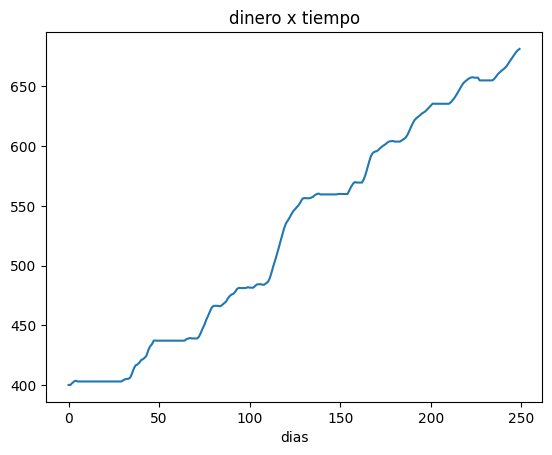

In [451]:
#print(dineroHist)

plt.title("dinero x tiempo")
plt.xlabel("dinero")
plt.xlabel("dias")
plt.plot(dineroHist) 
plt.show()

